<a href="https://colab.research.google.com/github/JuanCarlosUNAL/Notebooks/blob/master/tf/BasicTextClasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Text Clasification
Using *StackOverflow* dataset try to predict the programing languaje that the text refers to

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import tarfile
import os

%matplotlib inline
tf.__version__

'2.3.0'

## Download dataset

In [2]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz

--2020-08-17 02:58:16--  http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6053168 (5.8M) [application/x-gzip]
Saving to: ‘stack_overflow_16k.tar.gz.2’

stack_overflow_16k. 100%[===================>]   5.77M  --.-KB/s    in 0.03s   

2020-08-17 02:58:16 (168 MB/s) - ‘stack_overflow_16k.tar.gz.2’ saved [6053168/6053168]



In [3]:
tar_dataset = tarfile.open('./stack_overflow_16k.tar.gz')
tar_dataset.extractall('/tmp')
tar_dataset.close()

In [4]:
os.listdir('/tmp/train')

['python', 'java', 'csharp', 'javascript']

In [5]:
trainig = tf.keras.preprocessing.text_dataset_from_directory('/tmp/train', validation_split=0.2, subset='training', seed=1)
validation = tf.keras.preprocessing.text_dataset_from_directory('/tmp/train', validation_split=0.2, subset='validation', seed=1)
testing = tf.keras.preprocessing.text_dataset_from_directory('/tmp/test')

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


## Prepare textVectorizer layer 

In [6]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(output_sequence_length=500, )

In [7]:
training_text = trainig.map(lambda x, y: x)
vectorize_layer.adapt(training_text)

In [21]:
text_to_vectorize = "this is an example of python code: hola mundo ardillita" #@param {type:"string"}
text_to_vectorize = np.array([text_to_vectorize])
gen_vector = vectorize_layer(text_to_vectorize).numpy()
print(f'shape: {gen_vector.shape}\nvector:\n{gen_vector}')

shape: (1, 500)
vector:
[[   13     6    32   137     9  2176    30 22717 58586     1     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0 

In [9]:
vocabulary_size = len(vectorize_layer.get_vocabulary())
print(f'there are {vocabulary_size} different words')

there are 99995 different words


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = trainig.map(vectorize_text)
val_ds = validation.map(vectorize_text)
test_ds = testing.map(vectorize_text)


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create model

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  tf.keras.layers.Embedding(vocabulary_size , 21),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(100, activation='relu'),
])

In [19]:
model.predict(np.array(['this an example text', 'i want to solve my python problem'])).shape

(2, 10500)

In [49]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  tf.keras.layers.Embedding(vocabulary_size , 30),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(4, activation='softmax'),
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 500, 30)           2999850   
_________________________________________________________________
flatten_9 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               1500100   
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)              

In [51]:
model.compile(
  optimizer=tf.keras.optimizers.RMSprop(0.01),
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'],
)

In [53]:
history = model.fit(
  trainig,
  epochs=20,
  validation_data=validation,
  verbose=2
)

Epoch 1/20
200/200 - 7s - loss: 1.1455 - accuracy: 0.4592 - val_loss: 1.1346 - val_accuracy: 0.5369
Epoch 2/20
200/200 - 7s - loss: 0.9583 - accuracy: 0.6014 - val_loss: 1.0044 - val_accuracy: 0.5944
Epoch 3/20
200/200 - 7s - loss: 0.6537 - accuracy: 0.7378 - val_loss: 1.1176 - val_accuracy: 0.6225
Epoch 4/20
200/200 - 7s - loss: 0.4254 - accuracy: 0.8428 - val_loss: 1.2441 - val_accuracy: 0.6350
Epoch 5/20
200/200 - 7s - loss: 0.2966 - accuracy: 0.8995 - val_loss: 1.9880 - val_accuracy: 0.6619
Epoch 6/20
200/200 - 7s - loss: 0.1975 - accuracy: 0.9395 - val_loss: 2.4284 - val_accuracy: 0.6369
Epoch 7/20
200/200 - 7s - loss: 0.1449 - accuracy: 0.9642 - val_loss: 3.5696 - val_accuracy: 0.6519
Epoch 8/20
200/200 - 7s - loss: 0.1380 - accuracy: 0.9750 - val_loss: 4.9610 - val_accuracy: 0.6131
Epoch 9/20
200/200 - 7s - loss: 0.1036 - accuracy: 0.9761 - val_loss: 3.7841 - val_accuracy: 0.6481
Epoch 10/20
200/200 - 7s - loss: 0.1106 - accuracy: 0.9845 - val_loss: 7.2647 - val_accuracy: 0.6050

## Evaluate model

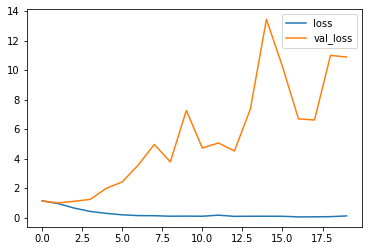

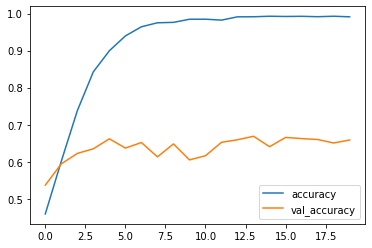

In [54]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot.line()
history_df[['accuracy', 'val_accuracy']].plot.line()
plt.show()

In [43]:
model.evaluate(testing)

250/250 [==============================] - 4s 16ms/step - loss: 2.6842 - accuracy: 0.6325


[2.684211015701294, 0.6324999928474426]